### Script ARIMA model

#### Import libraries

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
import warnings
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

#### Load the data

In [2]:
data = pd.read_csv('/Users/nicolasdemuynck/BeCode/GNT-ARAI-1.25/Content/00.Use cases/arinti/20200124_ews_observations.csv',
                   low_memory=False)

#### Data preprocessing

In [3]:
data.dropna(inplace=True)

In [4]:
data['ObservationDate'] =  pd.to_datetime(data['ObservationDate']) #make datetime object
data.dtypes

PatientId                   int64
ObservationDate    datetime64[ns]
EwsProcedure               object
EWS_Total                   int64
SBP                       float64
SBP_Score                 float64
LOC                        object
LOC_Score                   int64
SpO2                      float64
SpO2_Score                float64
Add_O2                     object
Add_O2_Score              float64
HR                          int64
HR_Score                    int64
RR                          int64
RR_Score                    int64
TEMP                      float64
TEMP_Score                  int64
dtype: object

In [5]:
print(data.LOC.unique())

['ALERT' 'NEW_CONFUSION' 'VOICE' 'PAIN' 'UNRESPONSIVE']


In [6]:
encoder = LabelEncoder ()

for i in data.columns:
    if data[i].dtype == object:
        data[i] = encoder.fit_transform(data[i])
print(data.LOC.unique())

[0 1 4 2 3]


In [7]:
df = data[['ObservationDate','PatientId', 'EWS_Total', 'SBP', 'LOC', 'SpO2', 'HR', 'RR','TEMP']]
df.head(5)

,ObservationDate,PatientId,EWS_Total,SBP,LOC,SpO2,HR,RR,TEMP
0,2019-05-01 13:27:50,29,0,143.0,0,96.0,80,18,36.6
2,2019-05-01 15:54:27,31,1,117.0,0,95.0,75,14,37.3
4,2019-05-01 17:03:16,33,0,135.0,0,97.0,89,14,36.1
8,2019-05-01 21:08:05,32,0,125.0,0,97.0,87,14,37.1
10,2019-05-01 21:13:21,34,1,117.0,0,95.0,64,13,36.6


In [8]:
df.set_index('ObservationDate', inplace = True)
df.head(5)

,PatientId,EWS_Total,SBP,LOC,SpO2,HR,RR,TEMP
ObservationDate,,,,,,,,
2019-05-01 13:27:50,29,0,143.0,0,96.0,80,18,36.6
2019-05-01 15:54:27,31,1,117.0,0,95.0,75,14,37.3
2019-05-01 17:03:16,33,0,135.0,0,97.0,89,14,36.1
2019-05-01 21:08:05,32,0,125.0,0,97.0,87,14,37.1
2019-05-01 21:13:21,34,1,117.0,0,95.0,64,13,36.6


In [9]:
df.shape

(160947, 8)

In [10]:
patient = df.loc[(df['PatientId'] == 1743)]
patient.head(5)

,PatientId,EWS_Total,SBP,LOC,SpO2,HR,RR,TEMP
ObservationDate,,,,,,,,
2019-06-15 13:32:39,1743,4,122.0,0,91.0,112,18,36.6
2019-06-15 20:22:36,1743,5,109.0,0,93.0,104,16,37.0
2019-06-16 14:23:34,1743,3,117.0,0,89.0,103,19,36.5
2019-06-16 19:49:24,1743,3,123.0,0,90.0,107,19,36.6
2019-06-17 04:39:15,1743,4,102.0,0,92.0,97,18,36.7


In [11]:
patient.shape

(616, 8)

#### Do seasonality test

In [47]:
adf_test = ADFTest(alpha=0.05)    
print(adf_test.should_diff(patient.SBP))

adf_test = ADFTest(alpha=0.05)
print(adf_test.should_diff(patient.LOC))

adf_test = ADFTest(alpha=0.05)
print(adf_test.should_diff(patient.SpO2))

adf_test = ADFTest(alpha=0.05)
print(adf_test.should_diff(patient.HR))

adf_test = ADFTest(alpha=0.05)
print(adf_test.should_diff(patient.RR))

adf_test = ADFTest(alpha=0.05)
print(adf_test.should_diff(patient.TEMP))

(0.01, False)
(0.01, False)
(0.01, False)
(0.01, False)
(0.01, False)
(0.01, False)


In [48]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(patient.SBP.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(patient.SpO2.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(patient.HR.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(patient.RR.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(patient.TEMP.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.812073
p-value: 0.056570
ADF Statistic: -4.333422
p-value: 0.000389
ADF Statistic: -8.942493
p-value: 0.000000
ADF Statistic: -3.694734
p-value: 0.004188
ADF Statistic: -5.092743
p-value: 0.000014


#### Manual plots

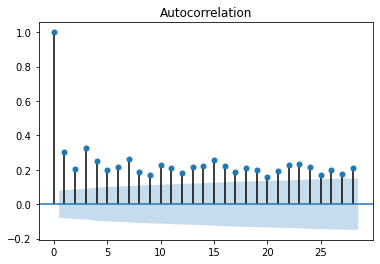

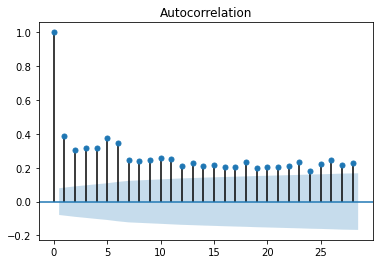

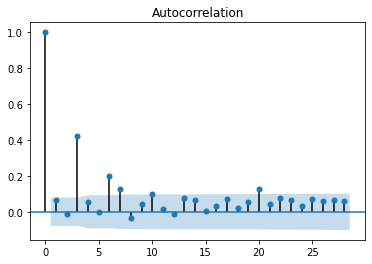

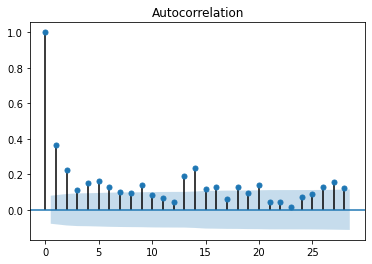

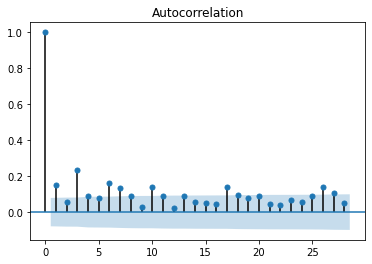

In [50]:
plot_acf(patient.SBP)
plt.show() #95% confidence intervals are drown (default)

plot_acf(patient.SpO2)
plt.show()

plot_acf(patient.HR)
plt.show()

plot_acf(patient.RR)
plt.show()

plot_acf(patient.TEMP)
plt.show()
# data is not stationairy
# if data tapers to 0 => MA model

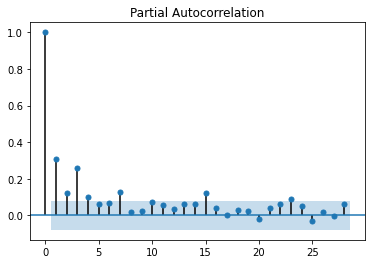

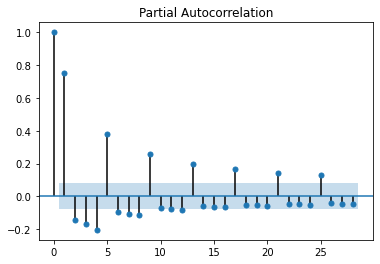

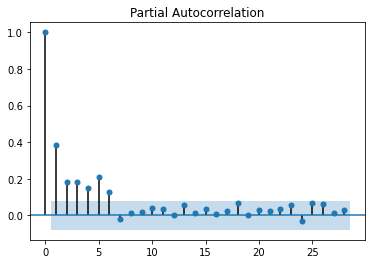

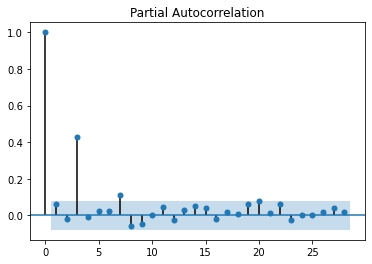

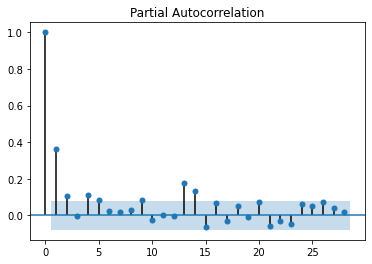

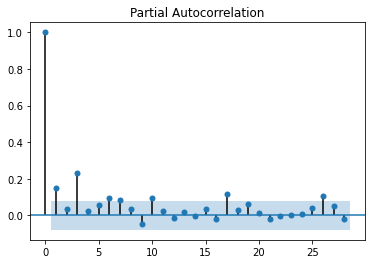

In [52]:
plot_pacf(patient.SBP)
plt.show()

plot_pacf(patient.LOC)
plt.show()

plot_pacf(patient.SpO2)
plt.show()

plot_pacf(patient.HR)
plt.show()

plot_pacf(patient.RR)
plt.show()

plot_pacf(patient.TEMP)
plt.show()

# if data tapers to zero => AR model

#### Grid search hyperparameters

In [25]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.80)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
    #test.reset_index(drop=True,inplace = True)
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

In [26]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [33]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10] # range it too large
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(patient.TEMP.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.242
ARIMA(0, 0, 1) MSE=0.228
ARIMA(0, 0, 2) MSE=0.232
ARIMA(0, 1, 0) MSE=0.228
ARIMA(0, 1, 1) MSE=0.192
ARIMA(0, 1, 2) MSE=0.195
ARIMA(0, 2, 0) MSE=0.606
ARIMA(0, 2, 1) MSE=0.228
ARIMA(0, 2, 2) MSE=0.190
ARIMA(1, 0, 0) MSE=0.227
ARIMA(1, 0, 1) MSE=0.206
ARIMA(1, 0, 2) MSE=0.213
ARIMA(1, 1, 0) MSE=0.206
ARIMA(1, 1, 1) MSE=0.194
ARIMA(1, 1, 2) MSE=0.189
ARIMA(1, 2, 0) MSE=0.377
ARIMA(1, 2, 1) MSE=0.206
ARIMA(1, 2, 2) MSE=0.193
ARIMA(2, 0, 0) MSE=0.232
ARIMA(2, 0, 1) MSE=0.221
ARIMA(2, 0, 2) MSE=0.206
ARIMA(2, 1, 0) MSE=0.224
ARIMA(2, 1, 1) MSE=0.207
ARIMA(2, 1, 2) MSE=0.206
ARIMA(2, 2, 0) MSE=0.353
ARIMA(2, 2, 1) MSE=0.224
ARIMA(2, 2, 2) MSE=0.207
ARIMA(4, 0, 0) MSE=0.219
ARIMA(4, 0, 1) MSE=0.214
ARIMA(4, 0, 2) MSE=0.209
ARIMA(4, 1, 0) MSE=0.219
ARIMA(4, 1, 1) MSE=0.203
ARIMA(4, 1, 2) MSE=0.205
ARIMA(4, 2, 0) MSE=0.314
ARIMA(4, 2, 1) MSE=0.220
ARIMA(4, 2, 2) MSE=0.227
ARIMA(6, 0, 0) MSE=0.217
ARIMA(6, 0, 1) MSE=0.214
ARIMA(6, 0, 2) MSE=0.212
ARIMA(6, 1, 0) MSE=0.219


In [42]:
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(patient.SBP.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=100.071
ARIMA(0, 0, 1) MSE=81.296
ARIMA(0, 0, 2) MSE=79.484
ARIMA(0, 1, 0) MSE=85.411
ARIMA(0, 1, 1) MSE=67.802
ARIMA(0, 1, 2) MSE=66.039
ARIMA(0, 2, 0) MSE=231.000
ARIMA(0, 2, 1) MSE=85.573
ARIMA(0, 2, 2) MSE=67.376
ARIMA(1, 0, 0) MSE=76.090
ARIMA(1, 0, 1) MSE=67.277
ARIMA(1, 0, 2) MSE=65.534
ARIMA(1, 1, 0) MSE=73.980
ARIMA(1, 1, 1) MSE=66.281
ARIMA(1, 1, 2) MSE=66.011
ARIMA(1, 2, 0) MSE=152.889
ARIMA(1, 2, 1) MSE=74.107
ARIMA(1, 2, 2) MSE=65.171
ARIMA(2, 0, 0) MSE=72.069
ARIMA(2, 0, 1) MSE=65.777
ARIMA(2, 0, 2) MSE=65.504
ARIMA(2, 1, 0) MSE=68.111
ARIMA(2, 1, 1) MSE=67.450
ARIMA(2, 1, 2) MSE=67.149
ARIMA(2, 2, 0) MSE=118.165
ARIMA(2, 2, 1) MSE=68.213
ARIMA(2, 2, 2) MSE=66.621
Best ARIMA(1, 2, 2) MSE=65.171


In [151]:
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(patient.SBP.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=100.071
ARIMA(0, 0, 1) MSE=81.276
ARIMA(0, 0, 2) MSE=79.462
ARIMA(0, 0, 3) MSE=73.554
ARIMA(0, 0, 4) MSE=70.507
ARIMA(0, 1, 0) MSE=85.569
ARIMA(0, 1, 1) MSE=71.002
ARIMA(0, 1, 2) MSE=69.569
ARIMA(0, 1, 3) MSE=70.166
ARIMA(0, 1, 4) MSE=69.485
ARIMA(0, 2, 0) MSE=231.413
ARIMA(0, 2, 1) MSE=85.922
ARIMA(0, 2, 2) MSE=67.072
ARIMA(0, 2, 3) MSE=65.115
ARIMA(0, 2, 4) MSE=66.201
ARIMA(1, 0, 0) MSE=76.086
ARIMA(1, 0, 1) MSE=67.276
ARIMA(1, 0, 2) MSE=65.534
ARIMA(1, 0, 3) MSE=66.661
ARIMA(1, 1, 0) MSE=74.115
ARIMA(1, 1, 1) MSE=69.764
ARIMA(1, 1, 2) MSE=70.051
ARIMA(1, 1, 3) MSE=70.111
ARIMA(1, 1, 4) MSE=70.148
ARIMA(1, 2, 0) MSE=153.164
ARIMA(2, 0, 0) MSE=72.072
ARIMA(2, 0, 1) MSE=65.776
ARIMA(2, 0, 3) MSE=63.966
ARIMA(2, 1, 0) MSE=68.236
ARIMA(2, 1, 1) MSE=70.418
ARIMA(2, 1, 2) MSE=70.222
ARIMA(2, 1, 3) MSE=70.530
ARIMA(2, 1, 4) MSE=69.746
ARIMA(2, 2, 0) MSE=118.382
ARIMA(3, 0, 0) MSE=66.142
ARIMA(3, 0, 1) MSE=65.001
ARIMA(3, 0, 2) MSE=63.832
ARIMA(3, 1, 0) MSE=66.782
ARIMA(3,

In [43]:
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(patient.SpO2.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=14.611
ARIMA(0, 0, 1) MSE=11.531
ARIMA(0, 0, 2) MSE=10.653
ARIMA(0, 1, 0) MSE=10.274
ARIMA(0, 1, 1) MSE=7.493
ARIMA(0, 1, 2) MSE=7.403
ARIMA(0, 2, 0) MSE=29.460
ARIMA(0, 2, 1) MSE=10.293
ARIMA(0, 2, 2) MSE=7.448
ARIMA(1, 0, 0) MSE=10.284
ARIMA(1, 0, 1) MSE=7.562
ARIMA(1, 0, 2) MSE=7.494
ARIMA(1, 1, 0) MSE=8.545
ARIMA(1, 1, 1) MSE=7.403
ARIMA(1, 1, 2) MSE=7.484
ARIMA(1, 2, 0) MSE=16.809
ARIMA(1, 2, 1) MSE=8.560
ARIMA(1, 2, 2) MSE=7.391
ARIMA(2, 0, 0) MSE=9.407
ARIMA(2, 0, 1) MSE=7.496
ARIMA(2, 0, 2) MSE=7.551
ARIMA(2, 1, 0) MSE=8.574
ARIMA(2, 1, 1) MSE=7.449
ARIMA(2, 1, 2) MSE=7.483
ARIMA(2, 2, 0) MSE=15.325
ARIMA(2, 2, 1) MSE=8.585
ARIMA(2, 2, 2) MSE=7.429
Best ARIMA(1, 2, 2) MSE=7.391


In [153]:
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(patient.SpO2.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=14.611
ARIMA(0, 0, 1) MSE=11.531
ARIMA(0, 0, 2) MSE=10.652
ARIMA(0, 0, 3) MSE=10.306
ARIMA(0, 0, 4) MSE=10.197
ARIMA(0, 1, 0) MSE=10.293
ARIMA(0, 1, 1) MSE=7.506
ARIMA(0, 1, 2) MSE=7.442
ARIMA(0, 1, 3) MSE=7.484
ARIMA(0, 1, 4) MSE=7.632
ARIMA(0, 2, 0) MSE=29.514
ARIMA(0, 2, 1) MSE=10.334
ARIMA(0, 2, 2) MSE=7.505
ARIMA(0, 2, 3) MSE=7.442
ARIMA(0, 2, 4) MSE=7.411
ARIMA(1, 0, 0) MSE=10.284
ARIMA(1, 0, 1) MSE=7.562
ARIMA(1, 0, 2) MSE=7.495
ARIMA(1, 0, 3) MSE=7.576
ARIMA(1, 0, 4) MSE=7.661
ARIMA(1, 1, 0) MSE=8.561
ARIMA(1, 1, 1) MSE=7.445
ARIMA(1, 1, 2) MSE=7.548
ARIMA(1, 1, 3) MSE=7.512
ARIMA(1, 1, 4) MSE=7.697
ARIMA(1, 2, 0) MSE=16.841
ARIMA(2, 0, 0) MSE=9.407
ARIMA(2, 0, 1) MSE=7.496
ARIMA(2, 0, 2) MSE=7.553
ARIMA(2, 0, 3) MSE=7.652
ARIMA(2, 0, 4) MSE=7.609
ARIMA(2, 1, 0) MSE=8.589
ARIMA(2, 1, 1) MSE=7.483
ARIMA(2, 1, 2) MSE=7.510
ARIMA(2, 1, 3) MSE=7.544
ARIMA(2, 1, 4) MSE=7.497
ARIMA(2, 2, 0) MSE=15.354
ARIMA(3, 0, 0) MSE=8.942
ARIMA(3, 0, 1) MSE=7.552
ARIMA(3, 0, 2)

In [44]:
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(patient.HR.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=74.756
ARIMA(0, 0, 1) MSE=73.458
ARIMA(0, 0, 2) MSE=74.378
ARIMA(0, 1, 0) MSE=110.597
ARIMA(0, 1, 1) MSE=74.356
ARIMA(0, 1, 2) MSE=76.676
ARIMA(0, 2, 0) MSE=319.105
ARIMA(0, 2, 1) MSE=110.797
ARIMA(0, 2, 2) MSE=75.812
ARIMA(1, 0, 0) MSE=73.579
ARIMA(1, 0, 1) MSE=69.572
ARIMA(1, 0, 2) MSE=71.937
ARIMA(1, 1, 0) MSE=89.427
ARIMA(1, 1, 1) MSE=75.921
ARIMA(1, 1, 2) MSE=70.445
ARIMA(1, 2, 0) MSE=214.053
ARIMA(1, 2, 1) MSE=89.585
ARIMA(1, 2, 2) MSE=114.587
ARIMA(2, 0, 0) MSE=74.970
ARIMA(2, 0, 1) MSE=73.918
ARIMA(2, 0, 2) MSE=68.514
ARIMA(2, 1, 0) MSE=65.717
ARIMA(2, 1, 1) MSE=71.395
ARIMA(2, 1, 2) MSE=75.561
ARIMA(2, 2, 0) MSE=113.408
ARIMA(2, 2, 1) MSE=65.826
ARIMA(2, 2, 2) MSE=71.126
Best ARIMA(2, 1, 0) MSE=65.717


In [45]:
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(patient.RR.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=12.109
ARIMA(0, 0, 1) MSE=10.843
ARIMA(0, 0, 2) MSE=10.307
ARIMA(0, 1, 0) MSE=14.484
ARIMA(0, 1, 1) MSE=10.758
ARIMA(0, 1, 2) MSE=10.015
ARIMA(0, 2, 0) MSE=41.089
ARIMA(0, 2, 1) MSE=14.510
ARIMA(0, 2, 2) MSE=10.781
ARIMA(1, 0, 0) MSE=10.362
ARIMA(1, 0, 1) MSE=10.220
ARIMA(1, 0, 2) MSE=10.343
ARIMA(1, 1, 0) MSE=12.082
ARIMA(1, 1, 1) MSE=9.807
ARIMA(1, 1, 2) MSE=9.833
ARIMA(1, 2, 0) MSE=23.430
ARIMA(1, 2, 1) MSE=12.108
ARIMA(1, 2, 2) MSE=9.989
ARIMA(2, 0, 0) MSE=10.255
ARIMA(2, 0, 1) MSE=10.456
ARIMA(2, 0, 2) MSE=10.253
ARIMA(2, 1, 0) MSE=11.908
ARIMA(2, 1, 1) MSE=9.835
ARIMA(2, 1, 2) MSE=9.840
ARIMA(2, 2, 0) MSE=20.587
ARIMA(2, 2, 1) MSE=11.933
ARIMA(2, 2, 2) MSE=11.596
Best ARIMA(1, 1, 1) MSE=9.807


### Fit an ARIMA model and plot residual errors

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  492
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -183.081
Date:                Tue, 12 Jan 2021   AIC                            374.162
Time:                        14:52:54   BIC                            390.947
Sample:                             0   HQIC                           380.753
                                - 492                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9369      0.043    -21.679      0.000      -1.022      -0.852
ma.L1         -0.0034      0.032     -0.107      0.915      -0.066       0.059
ma.L2         -0.9493      0.031    -31.012      0.0

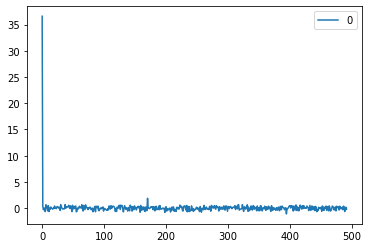

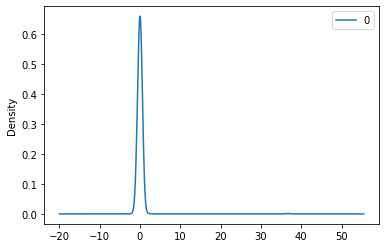

                0
count  492.000000
mean     0.070092
std      1.687220
min     -1.102348
25%     -0.232516
50%      0.008885
75%      0.260277
max     36.600000


In [53]:
# split into train and test sets
X = patient.TEMP.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# fit model
model = ARIMA(train, order=(1,1,2))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = DataFrame(model_fit.resid) 
residuals.plot()
plt.show()

# density plot of residuals 
residuals.plot(kind='kde') 
plt.show()

# summary stats of residuals
print(residuals.describe())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  492
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -1824.791
Date:                Tue, 12 Jan 2021   AIC                           3657.583
Time:                        14:54:49   BIC                           3674.361
Sample:                             0   HQIC                          3664.172
                                - 492                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0508      0.024      2.087      0.037       0.003       0.099
ma.L1         -1.9691      0.015   -130.373      0.000      -1.999      -1.939
ma.L2          0.9694      0.015     64.144      0.0

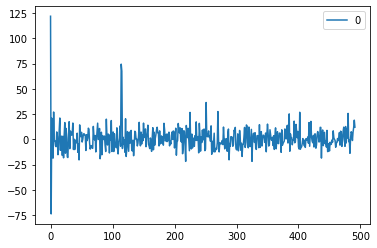

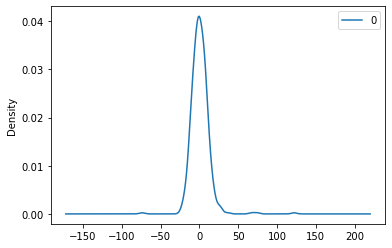

                0
count  492.000000
mean     0.765774
std     11.928947
min    -73.995044
25%     -5.890840
50%     -0.102949
75%      6.494575
max    122.000000


In [55]:
# split into train and test sets
X = patient.SBP.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# fit model
model = ARIMA(train, order=(1,2,2))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = DataFrame(model_fit.resid) 
residuals.plot()
plt.show()

# density plot of residuals 
residuals.plot(kind='kde') 
plt.show()

# summary stats of residuals
print(residuals.describe())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  492
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -1071.759
Date:                Tue, 12 Jan 2021   AIC                           2151.517
Time:                        14:56:19   BIC                           2168.295
Sample:                             0   HQIC                          2158.106
                                - 492                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0857      0.048      1.772      0.076      -0.009       0.181
ma.L1         -1.9600      0.044    -44.615      0.000      -2.046      -1.874
ma.L2          0.9601      0.042     22.870      0.0

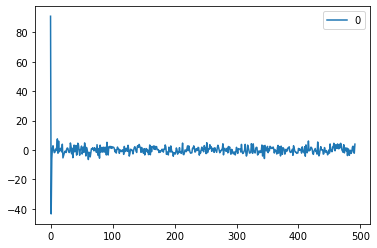

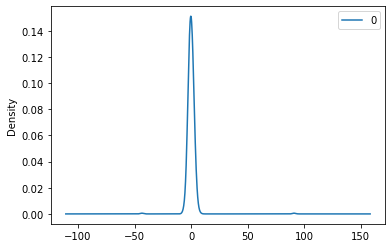

                0
count  492.000000
mean     0.058493
std      5.042488
min    -43.499848
25%     -1.560013
50%     -0.038939
75%      1.503464
max     91.000000


In [56]:
# split into train and test sets
X = patient.SpO2.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# fit model
model = ARIMA(train, order=(1,2,2))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = DataFrame(model_fit.resid) 
residuals.plot()
plt.show()

# density plot of residuals 
residuals.plot(kind='kde') 
plt.show()

# summary stats of residuals
print(residuals.describe())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  492
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1676.020
Date:                Tue, 12 Jan 2021   AIC                           3358.040
Time:                        14:58:26   BIC                           3370.629
Sample:                             0   HQIC                          3362.984
                                - 492                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7532      0.034    -22.267      0.000      -0.819      -0.687
ar.L2         -0.6351      0.037    -16.962      0.000      -0.708      -0.562
sigma2        53.8660      3.805     14.157      0.0

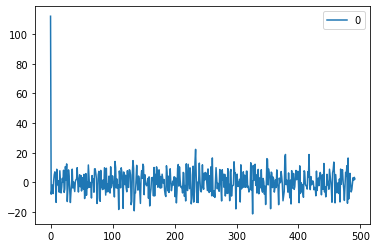

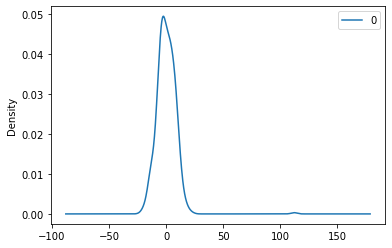

                0
count  492.000000
mean     0.161141
std      8.914862
min    -21.300993
25%     -4.912107
50%     -0.213716
75%      5.376156
max    112.000000


In [58]:
# split into train and test sets
X = patient.HR.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# fit model
model = ARIMA(train, order=(2,1,0))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = DataFrame(model_fit.resid) 
residuals.plot()
plt.show()

# density plot of residuals 
residuals.plot(kind='kde') 
plt.show()

# summary stats of residuals
print(residuals.describe())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  492
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -787.845
Date:                Tue, 12 Jan 2021   AIC                           1581.690
Time:                        14:59:28   BIC                           1594.279
Sample:                             0   HQIC                          1586.634
                                - 492                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2612      0.034      7.659      0.000       0.194       0.328
ma.L1         -0.9807      0.012    -80.314      0.000      -1.005      -0.957
sigma2         1.4415      0.074     19.434      0.0

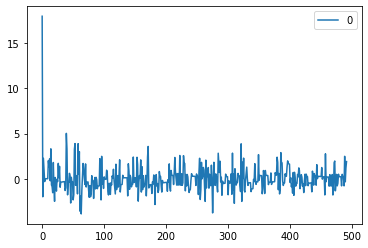

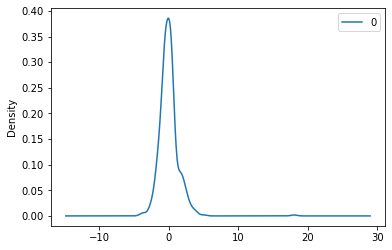

                0
count  492.000000
mean    -0.003411
std      1.453635
min     -3.898643
25%     -0.723935
50%     -0.077370
75%      0.424955
max     18.000000


In [60]:
# split into train and test sets
X = patient.RR.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# fit model
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = DataFrame(model_fit.resid) 
residuals.plot()
plt.show()

# density plot of residuals 
residuals.plot(kind='kde') 
plt.show()

# summary stats of residuals
print(residuals.describe())

### evaluate an ARIMA model using a walk-forward validation

predicted=36.614485, expected=36.500000
predicted=36.661813, expected=36.500000
predicted=36.609399, expected=36.500000
predicted=36.653576, expected=36.700000
predicted=36.615424, expected=36.600000
predicted=36.650130, expected=36.800000
predicted=36.625647, expected=36.700000
predicted=36.651801, expected=37.200000
predicted=36.654676, expected=37.300000
predicted=36.682059, expected=36.900000
predicted=36.666715, expected=37.400000
predicted=36.723624, expected=37.300000
predicted=36.705164, expected=37.500000
predicted=36.782761, expected=36.400000
predicted=36.680900, expected=36.300000
predicted=36.736717, expected=36.800000
predicted=36.694226, expected=37.100000
predicted=36.764920, expected=37.200000
predicted=36.737110, expected=37.200000
predicted=36.800482, expected=36.500000
predicted=36.711005, expected=37.000000
predicted=36.817354, expected=36.100000
predicted=36.655811, expected=37.000000
predicted=36.826329, expected=36.600000
predicted=36.666183, expected=36.800000


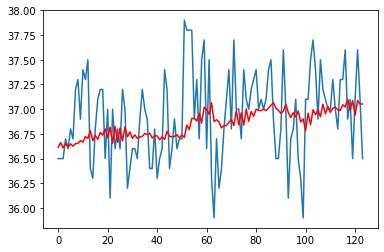

In [62]:
# split into train and test sets
X = patient.TEMP.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions)) 
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes 
plt.plot(test)
plt.plot(predictions, color='red') 
plt.show()

predicted=101.085633, expected=113.000000
predicted=101.643445, expected=113.000000
predicted=102.224230, expected=113.000000
predicted=102.823765, expected=111.000000
predicted=103.211311, expected=96.000000
predicted=101.978528, expected=111.000000
predicted=103.349146, expected=93.000000
predicted=101.838239, expected=99.000000
predicted=102.024341, expected=102.000000
predicted=102.204329, expected=98.000000
predicted=101.794752, expected=106.000000
predicted=102.452470, expected=88.000000
predicted=100.819050, expected=93.000000
predicted=100.722918, expected=105.000000
predicted=101.597590, expected=108.000000
predicted=102.049358, expected=102.000000
predicted=101.722060, expected=120.000000
predicted=103.553211, expected=105.000000
predicted=102.821688, expected=98.000000
predicted=102.229023, expected=99.000000
predicted=102.155179, expected=98.000000
predicted=101.929532, expected=95.000000
predicted=101.465177, expected=105.000000
predicted=102.207244, expected=100.000000
pr

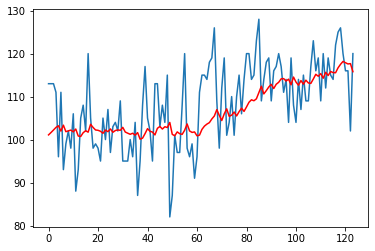

In [63]:
# split into train and test sets
X = patient.SBP.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,2,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions)) 
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes 
plt.plot(test)
plt.plot(predictions, color='red') 
plt.show()

predicted=89.691835, expected=94.000000
predicted=89.994235, expected=93.000000
predicted=90.079798, expected=94.000000
predicted=90.410160, expected=88.000000
predicted=89.674465, expected=96.000000
predicted=90.805046, expected=96.000000
predicted=91.252708, expected=100.000000
predicted=92.599893, expected=98.000000
predicted=93.321981, expected=90.000000
predicted=91.936276, expected=94.000000
predicted=92.690490, expected=92.000000
predicted=92.401693, expected=97.000000
predicted=93.510216, expected=92.000000
predicted=92.912210, expected=92.000000
predicted=92.782656, expected=92.000000
predicted=92.680628, expected=92.000000
predicted=92.604457, expected=91.000000
predicted=92.339483, expected=93.000000
predicted=92.586740, expected=90.000000
predicted=92.067387, expected=97.000000
predicted=93.138942, expected=92.000000
predicted=92.638806, expected=91.000000
predicted=92.396875, expected=93.000000
predicted=92.617372, expected=94.000000
predicted=92.832344, expected=96.000000

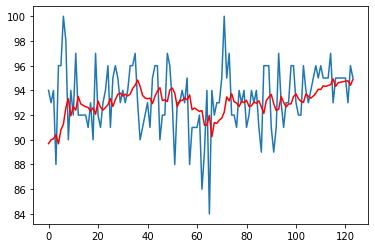

In [64]:
# split into train and test sets
X = patient.SpO2.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,2,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions)) 
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes 
plt.plot(test)
plt.plot(predictions, color='red') 
plt.show()

predicted=97.118075, expected=95.000000
predicted=97.141429, expected=95.000000
predicted=96.270082, expected=95.000000
predicted=95.000000, expected=96.000000
predicted=95.246987, expected=105.000000
predicted=97.589963, expected=98.000000
predicted=97.555296, expected=96.000000
predicted=101.950608, expected=96.000000
predicted=97.268017, expected=108.000000
predicted=98.974350, expected=107.000000
predicted=100.148050, expected=106.000000
predicted=107.381407, expected=105.000000
predicted=106.381260, expected=106.000000
predicted=105.882604, expected=99.000000
predicted=103.613981, expected=102.000000
predicted=104.174876, expected=105.000000
predicted=100.856855, expected=104.000000
predicted=102.854154, expected=105.000000
predicted=104.882598, expected=104.000000
predicted=104.117418, expected=104.000000
predicted=104.631445, expected=107.000000
predicted=104.753299, expected=111.000000
predicted=106.112096, expected=110.000000
predicted=108.224382, expected=103.000000
predicted

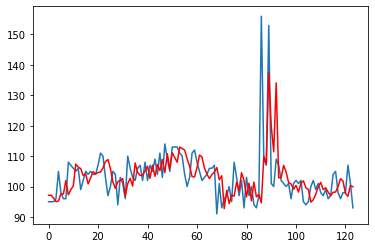

In [65]:
# split into train and test sets
X = patient.HR.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions)) 
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes 
plt.plot(test)
plt.plot(predictions, color='red') 
plt.show()

predicted=18.400230, expected=24.000000
predicted=19.660298, expected=32.000000
predicted=23.506901, expected=26.000000
predicted=21.669810, expected=22.000000
predicted=20.102782, expected=16.000000
predicted=17.428178, expected=18.000000
predicted=18.258131, expected=16.000000
predicted=17.350628, expected=17.000000
predicted=17.736659, expected=20.000000
predicted=19.022113, expected=20.000000
predicted=19.062039, expected=27.000000
predicted=22.256594, expected=15.000000
predicted=17.303603, expected=18.000000
predicted=18.402459, expected=18.000000
predicted=18.381563, expected=24.000000
predicted=20.719357, expected=25.000000
predicted=21.387556, expected=24.000000
predicted=21.259219, expected=15.000000
predicted=17.660614, expected=20.000000
predicted=19.548979, expected=19.000000
predicted=19.181227, expected=20.000000
predicted=19.564274, expected=14.000000
predicted=17.232316, expected=16.000000
predicted=17.826752, expected=19.000000
predicted=18.914493, expected=20.000000


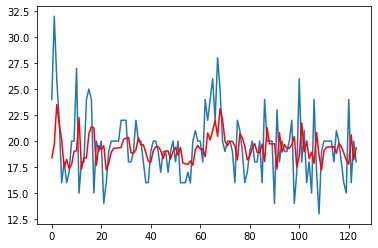

In [66]:
# split into train and test sets
X = patient.RR.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions)) 
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes 
plt.plot(test)
plt.plot(predictions, color='red') 
plt.show()

### Calculate and review confidence intervals

In [92]:
# split into train and test sets
X = patient.TEMP.values
X = X.astype('float64')
size = len(X) - 1
train, test = X[0:size], X[size:]
# fit an ARIMA model
model = ARIMA(train, order=(1,1,2))
model_fit = model.fit()
# forecast
result = model_fit.get_forecast()
# summarize forecast and confidence intervals
print('Expected: %.3f' % result.predicted_mean)
print('Forecast: %.3f' % test[0])
print('Standard Error: %.3f' % result.se_mean)
ci = result.conf_int(0.05)
print('95%% Interval: %.3f to %.3f' % (ci[0,0], ci[0,1]))

Expected: 37.052
Forecast: 36.500
Standard Error: 0.368
95% Interval: 36.332 to 37.773


In [91]:
# split data into train and test setes
X = patient.TEMP.values
X = X.astype('float64')
size = len(X) - 1
train, test = X[0:size], X[size:]

# fit an ARIMA model
model = ARIMA(train, order=(1,1,2))
model_fit = model.fit()
result = model_fit.get_forecast()
forecast = result.predicted_mean

# summarize confidence intervals
intervals = [0.2, 0.1, 0.05, 0.01]
for a in intervals:
    ci = result.conf_int(alpha=a)
    print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, ci[0,0], ci[0,1]))

80.0% Confidence Interval: 37.052 between 36.581 and 37.524
90.0% Confidence Interval: 37.052 between 36.448 and 37.657
95.0% Confidence Interval: 37.052 between 36.332 and 37.773
99.0% Confidence Interval: 37.052 between 36.105 and 38.000


In [94]:
# split into train and test sets
X = patient.SBP.values
X = X.astype('float64')
size = len(X) - 1
train, test = X[0:size], X[size:]
# fit an ARIMA model
model = ARIMA(train, order=(1,2,2))
model_fit = model.fit()
# forecast
result = model_fit.get_forecast()
# summarize forecast and confidence intervals
print('Expected: %.3f' % result.predicted_mean)
print('Forecast: %.3f' % test[0])
print('Standard Error: %.3f' % result.se_mean)
ci = result.conf_int(0.05)
print('95%% Interval: %.3f to %.3f' % (ci[0,0], ci[0,1]))

Expected: 115.798
Forecast: 120.000
Standard Error: 9.561
95% Interval: 97.059 to 134.538


In [95]:
# split data into train and test setes
X = patient.SpO2.values
X = X.astype('float64')
size = len(X) - 1
train, test = X[0:size], X[size:]

# fit an ARIMA model
model = ARIMA(train, order=(1,2,2))
model_fit = model.fit()
result = model_fit.get_forecast()
forecast = result.predicted_mean

# summarize confidence intervals
intervals = [0.2, 0.1, 0.05, 0.01]
for a in intervals:
    ci = result.conf_int(alpha=a)
    print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, ci[0,0], ci[0,1]))

80.0% Confidence Interval: 94.887 between 91.994 and 97.781
90.0% Confidence Interval: 94.887 between 91.174 and 98.601
95.0% Confidence Interval: 94.887 between 90.463 and 99.312
99.0% Confidence Interval: 94.887 between 89.073 and 100.702


In [98]:
# split into train and test sets
X = patient.SpO2.values
X = X.astype('float64')
size = len(X) - 1
train, test = X[0:size], X[size:]
# fit an ARIMA model
model = ARIMA(train, order=(1,2,2))
model_fit = model.fit()
# forecast
result = model_fit.get_forecast()
# summarize forecast and confidence intervals
print('Expected: %.3f' % result.predicted_mean)
print('Forecast: %.3f' % test[0])
print('Standard Error: %.3f' % result.se_mean)
ci = result.conf_int(0.05)
print('95%% Interval: %.3f to %.3f' % (ci[0,0], ci[0,1]))

Expected: 94.887
Forecast: 95.000
Standard Error: 2.257
95% Interval: 90.463 to 99.312


In [82]:
# split data into train and test setes
X = patient.SpO2.values
X = X.astype('float64')
size = len(X) - 1
train, test = X[0:size], X[size:]

# fit an ARIMA model
model = ARIMA(train, order=(1,2,2))
model_fit = model.fit()
result = model_fit.get_forecast()
forecast = result.predicted_mean

# summarize confidence intervals
intervals = [0.2, 0.1, 0.05, 0.01]
for a in intervals:
    ci = result.conf_int(alpha=a)
    print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, ci[0,0], ci[0,1]))

80.0% Confidence Interval: 94.887 between 91.994 and 97.781
90.0% Confidence Interval: 94.887 between 91.174 and 98.601
95.0% Confidence Interval: 94.887 between 90.463 and 99.312
99.0% Confidence Interval: 94.887 between 89.073 and 100.702


In [96]:
# split into train and test sets
X = patient.HR.values
X = X.astype('int64')
size = len(X) - 1
train, test = X[0:size], X[size:]
# fit an ARIMA model
model = ARIMA(train, order=(2,1,0))
model_fit = model.fit()
# forecast
result = model_fit.get_forecast()
# summarize forecast and confidence intervals
print('Expected: %.3f' % result.predicted_mean)
print('Forecast: %.3f' % test[0])
print('Standard Error: %.3f' % result.se_mean)
ci = result.conf_int(0.05)
print('95%% Interval: %.3f to %.3f' % (ci[0,0], ci[0,1]))

Expected: 99.921
Forecast: 93.000
Standard Error: 7.495
95% Interval: 85.231 to 114.610


In [84]:
# split data into train and test setes
X = patient.HR.values
X = X.astype('int64')
size = len(X) - 1
train, test = X[0:size], X[size:]

# fit an ARIMA model
model = ARIMA(train, order=(2,1,0))
model_fit = model.fit()
result = model_fit.get_forecast()
forecast = result.predicted_mean

# summarize confidence intervals
intervals = [0.2, 0.1, 0.05, 0.01]
for a in intervals:
    ci = result.conf_int(alpha=a)
    print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, ci[0,0], ci[0,1]))

80.0% Confidence Interval: 99.921 between 90.316 and 109.525
90.0% Confidence Interval: 99.921 between 87.593 and 112.248
95.0% Confidence Interval: 99.921 between 85.231 and 114.610
99.0% Confidence Interval: 99.921 between 80.616 and 119.225


In [97]:
# split into train and test sets
X = patient.RR.values
X = X.astype('int64')
size = len(X) - 1
train, test = X[0:size], X[size:]
# fit an ARIMA model
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()
# forecast
result = model_fit.get_forecast()
# summarize forecast and confidence intervals
print('Expected: %.3f' % result.predicted_mean)
print('Forecast: %.3f' % test[0])
print('Standard Error: %.3f' % result.se_mean)
ci = result.conf_int(0.05)
print('95%% Interval: %.3f to %.3f' % (ci[0,0], ci[0,1]))

Expected: 19.347
Forecast: 18.000
Standard Error: 1.757
95% Interval: 15.904 to 22.791


In [85]:
# split data into train and test setes
X = patient.RR.values
X = X.astype('int64')
size = len(X) - 1
train, test = X[0:size], X[size:]

# fit an ARIMA model
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()
result = model_fit.get_forecast()
forecast = result.predicted_mean

# summarize confidence intervals
intervals = [0.2, 0.1, 0.05, 0.01]
for a in intervals:
    ci = result.conf_int(alpha=a)
    print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, ci[0,0], ci[0,1]))

80.0% Confidence Interval: 19.347 between 17.096 and 21.599
90.0% Confidence Interval: 19.347 between 16.457 and 22.237
95.0% Confidence Interval: 19.347 between 15.904 and 22.791
99.0% Confidence Interval: 19.347 between 14.822 and 23.873


### Plotting the confidence intervals

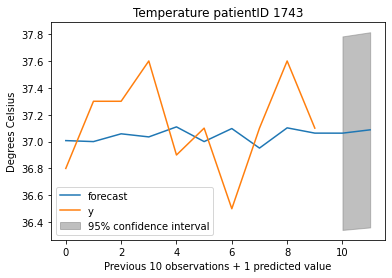

In [145]:
# plot the confidence intervals for an ARIMA forecast
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA

# split into train and test sets
X = patient.TEMP.values
X = X.astype('float64')
size = len(X) - 1
train, test = X[0:size], X[size:]
# fit an ARIMA model
model = ARIMA(train, order=(1,1,2))
model_fit = model.fit()
# plot some history and the forecast with confidence intervals 
model_fit.plot_predict(len(train)-10, len(train)+1) 
pyplot.legend(loc='bottom left')
pyplot.title('Temperature patientID 1743')
pyplot.xlabel('Previous 10 observations + 1 predicted value')
pyplot.ylabel('Degrees Celsius')
pyplot.show()

In [150]:
# plot the confidence intervals for an ARIMA forecast
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA

# split into train and test sets
X = patient.SBP.values
X = X.astype('float64')
size = len(X) - 1
train, test = X[0:size], X[size:]
# fit an ARIMA model
model = ARIMA(train, order=(1,2,2))
model_fit = model.fit()
# plot some history and the forecast with confidence intervals 
model_fit.plot_predict(len(train)-10, len(train)+1) 
pyplot.legend(loc='upper left')
pyplot.show()

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

In [148]:
# plot the confidence intervals for an ARIMA forecast
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA

# split into train and test sets
X = patient.SpO2.values
X = X.astype('float64')
size = len(X) - 1
train, test = X[0:size], X[size:]
# fit an ARIMA model
model = ARIMA(train, order=(1,2,2))
model_fit = model.fit()
# plot some history and the forecast with confidence intervals 
model_fit.plot_predict(len(train)-10, len(train)+1) 
pyplot.legend(loc='upper left')
pyplot.show()

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

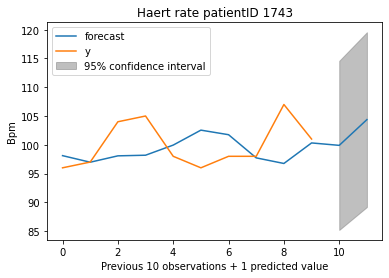

In [143]:
# plot the confidence intervals for an ARIMA forecast
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA

# split into train and test sets
X = patient.HR.values
X = X.astype('int64')
size = len(X) - 1
train, test = X[0:size], X[size:]
# fit an ARIMA model
model = ARIMA(train, order=(2,1,0))
model_fit = model.fit()
# plot some history and the forecast with confidence intervals 
model_fit.plot_predict(len(train)-10, len(train)+1) 
pyplot.legend(loc='upper left')
pyplot.title('Haert rate patientID 1743')
pyplot.xlabel('Previous 10 observations + 1 predicted value')
pyplot.ylabel('Bpm')
pyplot.show()

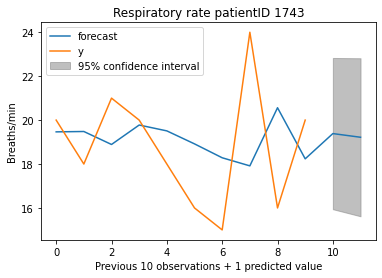

In [146]:
# plot the confidence intervals for an ARIMA forecast
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA

# split into train and test sets
X = patient.RR.values
X = X.astype('int64')
size = len(X) - 1
train, test = X[0:size], X[size:]
# fit an ARIMA model
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()
# plot some history and the forecast with confidence intervals 
model_fit.plot_predict(len(train)-10, len(train)+1) 
pyplot.title('Respiratory rate patientID 1743')
pyplot.ylabel('Breaths/min')
pyplot.xlabel('Previous 10 observations + 1 predicted value')
pyplot.legend(loc='upper left')
pyplot.show()